<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU, Input, TimeDistributed, CategoryEncoding, SimpleRNN
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences # se utilizará para padding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

# Para descargas desde textos.info
import urllib.request

# Para leer y parsear el texto en HTML
import bs4 as bs

### Datos
Utilizaremos como dataset la biblia. Utilizaremos sólo un 5% (ignorando previamente el primer 5%, para saltar el Génesis que quizas no es una parte tan representativa al resto del texto).

Se intentó inicialmente procesar un 10%, para tener una longitud de texto similar a la provista el en dataset de ejemplo de la materia (La vuelta al mundo en 80 días), pero el tiempo de procesamiento necesario para las redes neuronales con arquitectura GRU y LSTM excedían el tiempo brindado por Colab, por lo que se procedió con sólo un 5% del texto.

Procederemos a quitar saltos de línea y el caracter de espacio no separable, por espacios simples, para simplificar el entrenamiento y predicción de caracteres.

In [3]:
raw_html = urllib.request.urlopen('https://www.textos.info/varios/biblia/ebook')
raw_html = raw_html.read()

# parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

# limpiar saltos de línea y otros caracteres extraños
article_text = article_text.replace('\r', ' ').replace('\n', ' ').replace('\xa0', ' ')
article_text = ' '.join(article_text.split())  # Esto elimina espacios dobles y los deja como uno solo


# saltar el 5% inicial
skip_portion = 0.05
total_len = len(article_text)
start = int(total_len * skip_portion)

# extraer solo el 5% después del salto
portion = 0.05
end = start + int(total_len * portion)

article_text = article_text[start:end]

In [3]:
# revisamos el comienzo de la porción extraída, vemos que se trata ya del libro Éxodo
article_text[:1000]

'ni siquiera un perro ladrará ni contra hombre ni contra bestia; para que sepáis cómo yahveh hace distinción entre egipto e israel. [8] entonces vendrán a mí todos estos siervos tuyos y se postrarán delante de mí, diciendo: sal, tú y todo el pueblo que te sigue. y entonces, saldré.» y, ardiendo en cólera, salió de la presencia de faraón. [9] y dijo yahveh a moisés: «no os escuchará faraón, para que así pueda yo multiplicar mis prodigios en la tierra de egipto.» [10] moisés y aarón obraron todos estos prodigios ante faraón; pero yahveh endureció el corazón de faraón, que no dejó salir de su país a los israelitas. [1] dijo yahveh a moisés y aarón en el país de egipto: [2] «este mes será para vosotros el comienzo de los meses; será el primero de los meses del año. [3] hablad a toda la comunidad de israel y decid: el día diez de este mes tomará cada uno para sí una res de ganado menor por familia, una res de ganado menor por casa. [4] y si la familia fuese demasiado reducida para una res d

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [4]:
# seleccionamos el tamaño de contexto
max_context_size = 100

Ordenamos el vocabulario para poder reproducir la tokenización para el caso en que levantemos un modelo previamente entrenado desde un archivo.

In [5]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = sorted(list(set(article_text)))

In [6]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

62

In [7]:
print(chars_vocab)

[' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '¡', '«', '»', '¿', 'á', 'é', 'í', 'ñ', 'ó', 'ú', 'ü', '—']


In [6]:
# Construimos los diccionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [7]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [10]:
tokenized_text[:1000]

[38,
 33,
 0,
 43,
 33,
 41,
 45,
 33,
 29,
 42,
 25,
 0,
 45,
 38,
 0,
 40,
 29,
 42,
 42,
 39,
 0,
 36,
 25,
 28,
 42,
 25,
 42,
 54,
 0,
 38,
 33,
 0,
 27,
 39,
 38,
 44,
 42,
 25,
 0,
 32,
 39,
 37,
 26,
 42,
 29,
 0,
 38,
 33,
 0,
 27,
 39,
 38,
 44,
 42,
 25,
 0,
 26,
 29,
 43,
 44,
 33,
 25,
 20,
 0,
 40,
 25,
 42,
 25,
 0,
 41,
 45,
 29,
 0,
 43,
 29,
 40,
 54,
 33,
 43,
 0,
 27,
 58,
 37,
 39,
 0,
 48,
 25,
 32,
 46,
 29,
 32,
 0,
 32,
 25,
 27,
 29,
 0,
 28,
 33,
 43,
 44,
 33,
 38,
 27,
 33,
 58,
 38,
 0,
 29,
 38,
 44,
 42,
 29,
 0,
 29,
 31,
 33,
 40,
 44,
 39,
 0,
 29,
 0,
 33,
 43,
 42,
 25,
 29,
 36,
 8,
 0,
 23,
 17,
 24,
 0,
 29,
 38,
 44,
 39,
 38,
 27,
 29,
 43,
 0,
 46,
 29,
 38,
 28,
 42,
 54,
 38,
 0,
 25,
 0,
 37,
 56,
 0,
 44,
 39,
 28,
 39,
 43,
 0,
 29,
 43,
 44,
 39,
 43,
 0,
 43,
 33,
 29,
 42,
 46,
 39,
 43,
 0,
 44,
 45,
 48,
 39,
 43,
 0,
 48,
 0,
 43,
 29,
 0,
 40,
 39,
 43,
 44,
 42,
 25,
 42,
 54,
 38,
 0,
 28,
 29,
 36,
 25,
 38,
 44,
 29,
 0,
 28,
 

### Organizando y estructurando el dataset

In [8]:
# separamos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [9]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [10]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [11]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [12]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [ ]:
X.shape

(198971, 100)

In [ ]:
X[0,:10]

array([38, 33,  0, 43, 33, 41, 45, 33, 29, 42])

In [ ]:
y[0,:10]

array([33,  0, 43, 33, 41, 45, 33, 29, 42, 25])

In [13]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [14]:
class PplCallback(keras.callbacks.Callback):

    """
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además, implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    """

    def __init__(self, val_data, history_ppl, model_name, patience=5):
      self.history_ppl = history_ppl
      self.model_name = model_name
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_name)
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

In [ ]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 62)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        52,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 62)       │        12,462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,062 (254.15 KB)

 Trainable params: 65,062 (254.15 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [25]:
model_name = "biblia_model.keras"

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl, model_name)], batch_size=256)

Epoch 1/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.4303
 mean perplexity: 6.5552245432680305 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - loss: 2.4299
Epoch 2/20
775/778 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8085
 mean perplexity: 5.514331385222349 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 1.8082
Epoch 3/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6525
 mean perplexity: 5.079603344743902 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 1.6525
Epoch 4/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5749
 mean perplexity: 4.926017561825839 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 1.5749
Epoch 5/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5297
 mean perplexity: 4.816973645036871 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 1.5297
Epoch 6/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4990
 mean perplexity: 4.781196

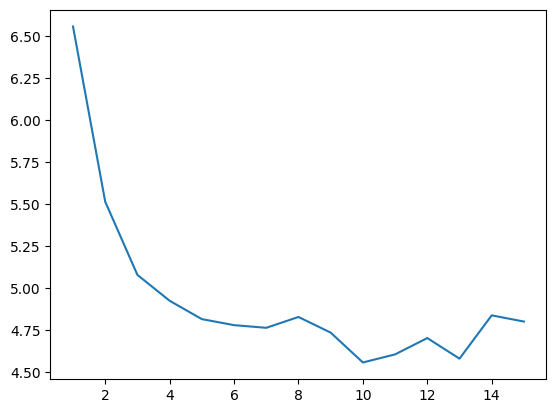

In [ ]:
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [26]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model(model_name)


### Predicción del próximo caracter

In [24]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.1 MB/s eta 0:00:00


Aunque es posible, quizás no es tan interesante ver solamente el próximo caractere propuesto por el modelo, por tanto no exploraremos mucho la predicción de a un caracter.

In [27]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])

    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego el caracter a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4571befe5043bda86b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━

### Generación de secuencias

In [16]:
def generate_seq(model, seed_text, max_length, n_tokens):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_tokens (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_tokens" agregadas
    """
    output_text = seed_text
	  # generamos una cantidad fija de caracteres
    for _ in range(n_tokens):
		    # Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		    # Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		    # Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		    # Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		    # Agrego los caracteres a la frase predicha
        output_text += out_word
    return output_text

In [15]:
input_text_1='y entonces moisés '

In [ ]:
generate_seq(model, input_text_1, max_length=max_context_size, n_tokens=100)

'y entonces moisés a la entrada de la tienda del encuentro y lo que la piel, en el sacerdote lo que se acercarán la car'

La primera conclusión es que, aunque la frase generada tenga un sentido sintáctico, formando palabras reales que figuran en la biblia, no se cuenta con un sentido semántico.

###  Beam search y muestreo aleatorio

In [17]:
# funcionalidades para hacer encoding y decoding
def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [18]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens, temp, mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model, num_beams, num_tokens, input, temp=1, mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_tokens-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_tokens):]

In [ ]:
# predicción con beam search
salidas = beam_search(model, num_beams=10, num_tokens=100, input=input_text_1)

In [ ]:
salidas[0]

array([48,  0, 29, 38, 44, 39, 38, 27, 29, 43,  0, 37, 39, 33, 43, 55, 43,
        0, 28, 29,  0, 36, 25,  0, 44, 33, 29, 38, 28, 25,  0, 28, 29, 36,
        0, 29, 38, 27, 45, 29, 38, 44, 42, 39,  0, 40, 25, 42, 25,  0, 29,
       36,  0, 43, 25, 27, 29, 42, 28, 39, 44, 29,  0, 36, 39,  0, 41, 45,
       29, 28, 25, 42, 54,  0, 33, 37, 40, 45, 42, 39,  0, 32, 25, 43, 44,
       25,  0, 36, 25,  0, 44, 33, 29, 38, 28, 25,  0, 28, 29, 36,  0, 29,
       38, 27, 45, 29, 38, 44, 42, 39,  0, 40, 25, 42, 25,  0, 29, 36])

In [ ]:
salidas_decoded = [decode(salida) for salida in salidas]

In [ ]:
for salida in salidas_decoded:
    print(salida)

y entonces moisés de la tienda del encuentro para el sacerdote lo quedará impuro hasta la tienda del encuentro para el
y entonces moisés de la tienda del encuentro para el sacerdote lo quedará impuro hasta la tienda del encuentro por el 
y entonces moisés de la tienda del encuentro para el sacerdote lo quedará impuro hasta la tienda del encuentro para qu
y entonces moisés de la tienda del encuentro para el sacerdote lo quedará impuro hasta la tienda del encuentro, con su
y entonces moisés de la tienda del encuentro para el sacerdote lo quedará impuro hasta la tienda del encuentro para la
y entonces moisés de la tienda del encuentro para el sacerdote lo quedará impuro hasta la tienda del encuentro. [14] e
y entonces moisés de la tienda del encuentro para el sacerdote lo quedará impuro hasta la tienda del encuentro. [15] e
y entonces moisés de la tienda del encuentro para el sacerdote lo quedará impuro hasta la tienda del encuentro y los i
y entonces moisés de la tienda del encuentro par

Se observa que todas las ramas cambian recién al final de la oración. Veamos probando la generación estocástica, con una temperatura más alta.

In [ ]:
salidas_sto = beam_search(model, num_beams=10, num_tokens=100, input=input_text_1, temp=2, mode='sto')

In [ ]:
salidas_sto_decoded = [decode(salida) for salida in salidas_sto]
for salida in salidas_sto_decoded:
    print(salida)

y entonces moisés la mesa colocarán las animales de enillas que ofrecerá uno los basas. [11] pero este es el sacerdote
y entonces moisés la mesa colocarán las animales de enillas que ofrecerá uno los basas. [11] pero este es el sacerdote
y entonces moisés la mesa colocarán las animales de enillas que ofrecerá uno los basas. [11] pero este es el sacerdote
y entonces moisés la mesa colocarán las animales de enillas que ofrecerá uno los basas. [11] pero este es el sacerdote
y entonces moisés la mesa colocarán las animales de enillas que ofrecerá uno los basas. [11] pero este es el sacerdosu
y entonces moisés la mesa colocarán las animales de enillas que ofrecerá uno los basas. [11] pero este es el sacerdote
y entonces moisés la mesa colocarán las animales de enillas que ofrecerá uno los basas. [11] pero este es el sacerdor;
y entonces moisés la mesa colocarán las animales de enillas que ofrecerá uno los basas. [11] pero este es el sacerdote
y entonces moisés la mesa colocarán las animales

Nuevamente no se presenta mucha variación hasta el final de las oraciones, y se comete en este caso el error de formar palabras inexistentes.

## Propuesta de Modelos

### Modelo con GRU

Intentaremos proponer un modelo que sea ligero y eficiente, apostando por:

- Embedding: Representaciones densas aprendidas (en lugar de codificación fija).

- GRU: Unidades recurrentes más potentes que las SimpleRNN.

Al reducir la capacidad del modelo (solo 64 unidades GRU) y cambiar la representación, puede perder capacidad expresiva.

In [ ]:
model_improved_gru = Sequential()

# Embedding en lugar de one-hot para reducir memoria necesaria, y pequeño reducir tiempo de procesamiento
model_improved_gru.add(Input(shape=(None,))) # Secuencia de longitud variable
model_improved_gru.add(Embedding(input_dim=vocab_size, output_dim=32))

# GRU liviana por cuestiones de tiempo de procesamiento.
model_improved_gru.add(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))

# Capa de salida
model_improved_gru.add(Dense(vocab_size, activation='softmax'))

# Compilar
model_improved_gru.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop'
)

model_improved_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 32)       │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 64)       │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 62)       │         4,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,830 (96.99 KB)

 Trainable params: 24,830 (96.99 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_name_improved_gru = "biblia_model_improved_gru.keras"

In [ ]:
history_ppl_improved_gru = []
hist = model_improved_gru.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_improved_gru, model_name_improved_gru)], batch_size=256)

Epoch 1/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 2.5215
 mean perplexity: 6.87416540926153 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 331s 416ms/step - loss: 2.5210
Epoch 2/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 1.7693
 mean perplexity: 6.06692397811196 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 379s 417ms/step - loss: 1.7693
Epoch 3/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 1.6403
 mean perplexity: 5.889168690551411 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 343s 367ms/step - loss: 1.6403
Epoch 4/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 1.5813
 mean perplexity: 5.769571178609675 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 323s 367ms/step - loss: 1.5812
Epoch 5/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 1.5478
 mean perplexity: 5.768272468176755 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 324s 370ms/step - loss: 1.5478
Epoch 6/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 1.5257
 mean perplex

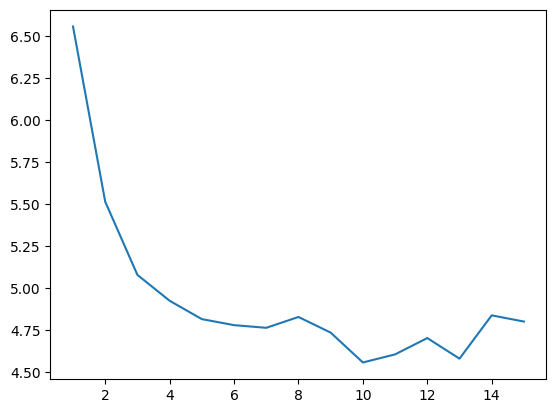

In [ ]:
# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

Podemos ver que en una época muy temprana deja de aprender, y la métrica de pérdida no es mejor que con el anterior modelo. Posiblemente porque simplificamos mucho el mismo con la intención de poder introducir neuronas con arquitectura GRU.

In [33]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_improved_gru = keras.models.load_model(model_name_improved_gru)

In [ ]:
generate_seq(model_improved_gru, input_text_1, max_length=max_context_size, n_tokens=100)

'y entonces moisés de la pueblo de la pueblo de la pueblo de la pueblo de la pueblo de la pueblo de la pueblo de la pue'

La primera impresión es que el modelo es peor que el anterior, dada la repetición de las mismas 3 palabras, una y otra vez. Veamos que pasa con bean search y agregando luego estocacidad.

In [ ]:
salidas = beam_search(model_improved_gru, num_beams=10, num_tokens=100, input=input_text_1)

In [ ]:
salidas_decoded = [decode(salida) for salida in salidas]
for salida in salidas_decoded:
    print(salida)

y entonces moisés para el sacrificio de la tienda de la tienda de la tienda de la tienda de la tienda de la tienda de 
y entonces moisés para el sacerdote de la tienda de la tienda de la tienda de la tienda de la tienda de la tienda de l
y entonces moisés para el sacerdote de la tienda de la tienda de la tienda de la tienda de la tienda de la tienda del 
y entonces moisés para el sacerdote de la tienda de la tienda de la tienda de la tienda de la tienda de los hijos de l
y entonces moisés para el sacerdote de la tienda de la tienda de la tienda de la tienda de la tienda de los hijos del 
y entonces moisés de la tienda de la tienda de la tienda de la tienda de la tienda de la tienda de la tienda de la tie
y entonces moisés de la tienda de los hijos de la tienda de la tienda de la tienda de la tienda de la tienda de la tie
y entonces moisés para el sacerdote de la tienda de la tienda de la tienda de la tienda de la tienda de la tierra de l
y entonces moisés para el sacerdote de la tienda

Aunque se consiguen algunas opciones más variadas, eventualmente cae nuevamente en la repetición, y se continúa el problema de no conseguir un texto con sentido semántico

In [ ]:
salidas_sto = beam_search(model_improved_gru, num_beams=10, num_tokens=100, input=input_text_1, temp=2, mode='sto')
salidas_sto_decoded = [decode(salida) for salida in salidas_sto]
for salida in salidas_sto_decoded:
    print(salida)

y entonces moisés de los compuran de yahveh, no hizo sobre tu puro de los pecasado. [31] del sacrificio, en los israel
y entonces moisés de los compuran de yahveh, no hizo sobre tu puro de los pecasado. [31] del sacrificio, en los israer
y entonces moisés de los compuran de yahveh, no hizo sobre tu puro de los pecasado. [31] del sacrificio, en los israel
y entonces moisés de los compuran de yahveh, no hizo sobre tu puro de los pecasado. [31] del sacrificio, en los israel
y entonces moisés de los compuran de yahveh, no hizo sobre tu puro de los pecasado. [31] del sacrificio, en los dios,.
y entonces moisés de los compuran de yahveh, no hizo sobre tu puro de los pecasado. [31] del sacrificio, en los israel
y entonces moisés de los compuran de yahveh, no hizo sobre tu puro de los pecasado. [31] del sacrificio, en los israel
y entonces moisés de los compuran de yahveh, no hizo sobre tu puro de los pecasado. [31] del sacrificio, en los israng
y entonces moisés de los compuran de yahveh, no 

Resulta sorprendente que se pierda la variedad adquirida con bean search, a pesar de agregar estocacidad y temperatura, que para el anterior modelo, había introducido bastante más variedad.

### Modelo con LSTM

Intentaremos ahora con un modelo que sea una alternativa sólida al baseline, apostando por un LSTM liviano con codificación explícita. Si bien no introduce cambios estructurales radicales, es una opción que busca equilibrio entre potencia y simplicidad, para ver si se puede evitar una arquitectura más profunda.

In [ ]:
model_improved_lstm = Sequential()

# Codificación one-hot con TimeDistributed
model_improved_lstm.add(TimeDistributed(
    CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"),
    input_shape=(None, 1)
))

# LSTM liviana
model_improved_lstm.add(LSTM(
    units=128,                  # Suficientemente potente, pero más liviana que 200-256
    return_sequences=True,
    dropout=0.2,
    recurrent_dropout=0.1
))

# Capa de salida
model_improved_lstm.add(Dense(vocab_size, activation='softmax'))

# Compilación
model_improved_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop'
)

model_improved_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 62)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │        97,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 62)       │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,790 (413.24 KB)

 Trainable params: 105,790 (413.24 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model_name_improved_lstm = "biblia_model_improved_lstm.keras"

In [ ]:
history_ppl_improved_lstm = []
hist = model_improved_lstm.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_improved_lstm, model_name_improved_lstm)], batch_size=256)

Epoch 1/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - loss: 2.8421
 mean perplexity: 8.967343544960022 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 792s 1s/step - loss: 2.8417 
Epoch 2/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - loss: 2.1493
 mean perplexity: 7.544358092004603 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 764s 982ms/step - loss: 2.1493
Epoch 3/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - loss: 2.0115
 mean perplexity: 6.942538561604239 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 785s 1s/step - loss: 2.0115 
Epoch 4/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - loss: 1.9311
 mean perplexity: 6.651729957623915 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 744s 957ms/step - loss: 1.9311
Epoch 5/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - loss: 1.8717
 mean perplexity: 6.43114350492304 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 784s 1s/step - loss: 1.8717 
Epoch 6/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - loss: 1.8234
 mean perplexity: 

In [22]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_improved_lstm = keras.models.load_model(model_name_improved_lstm)

In [23]:
generate_seq(model_improved_lstm, input_text_1, max_length=max_context_size, n_tokens=100)

'y entonces moisés de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la tienda del en'

In [24]:
salidas = beam_search(model_improved_lstm, num_beams=10, num_tokens=100, input=input_text_1)
salidas_decoded = [decode(salida) for salida in salidas]
for salida in salidas_decoded:
    print(salida)

y entonces moisés de la tienda de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la 
y entonces moisés de la tienda del encuentro de la tienda de la tienda del encuentro de la tienda del encuentro de la 
y entonces moisés de la tienda del encuentro de la tienda del encuentro de la tienda de la tienda del encuentro de la 
y entonces moisés de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la tienda del en
y entonces moisés de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la tienda de la 
y entonces moisés de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la tienda del sa
y entonces moisés de la tienda de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de los
y entonces moisés de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la tienda del ca
y entonces moisés de la tienda del encuentro de 

In [25]:
salidas_sto = beam_search(model_improved_lstm, num_beams=10, num_tokens=100, input=input_text_1, temp=2, mode='sto')
salidas_sto_decoded = [decode(salida) for salida in salidas_sto]
for salida in salidas_sto_decoded:
    print(salida)

y entonces moisés a los israelitas, de sus honos los hijos y los entras y tomas trabajos que habla sobre el pacado. [9
y entonces moisés a los israelitas, de sus honos los hijos y los entras y tomas trabajos que habla sobre el pacado. y 
y entonces moisés a los israelitas, de sus honos los hijos y los entras y tomas trabajos que habla sobre el pacado. y 
y entonces moisés a los israelitas, de sus honos los hijos y los entras y tomas trabajos que habla sobre el pacado. [n
y entonces moisés a los israelitas, de sus honos los hijos y los entras y tomas trabajos que habla sobre el pacado. [2
y entonces moisés a los israelitas, de sus honos los hijos y los entras y tomas trabajos que habla sobre el pacado. [2
y entonces moisés a los israelitas, de sus honos los hijos y los entras y tomas trabajos que habla sobre el pacado. [1
y entonces moisés a los israelitas, de sus honos los hijos y los entras y tomas trabajos que habla sobre el pacado. y.
y entonces moisés a los israelitas, de sus honos

Se repiten los mismos problemas que con el modelo usando arquitectura GRU para las neuronas.

Veamos que ocurre con las 3 redes, con un par de inputs distintos, con distintas longitudes y distinta cantidad de tokens a generar:

In [19]:
input_text_2 = "y descendió fuego del cielo, y consumió el altar y el sacrificio, "
input_text_3 = "y habló dios, diciendo "
input_text_4 = "y "

In [51]:
inputs = [
    ("input_text_2", input_text_2, 150),
    ("input_text_3", input_text_3, 40),
    ("input_text_4", input_text_4, 100),
]

models = [
    ("model", model),
    ("model_improved_gru", model_improved_gru),
    ("model_improved_lstm", model_improved_lstm),
]

In [54]:
import textwrap

def print_wrapped(text, width=120):
    for line in textwrap.wrap(text, width):
        print(line)

for input_name, input_text, n_tokens in inputs:
    print(f"\n\n{'='*40}")
    print(f"PROCESSING {input_name.upper()}")
    print(f"{'='*40}\n")

    # ----- SEQUENTIAL GENERATION -----
    print(">>> SEQUENTIAL GENERATION (generate_seq)\n")
    for model_name, model_instance in models:
        print(f"--- {model_name} ---")
        print(generate_seq(model_instance, input_text, max_length=max_context_size, n_tokens=n_tokens))
        print()

    # ----- BEAM SEARCH (DETERMINISTIC) -----
    print(">>> BEAM SEARCH (deterministic)\n")
    for model_name, model_instance in models:
        print(f"--- {model_name} ---")
        salidas = beam_search(model_instance, num_beams=10, num_tokens=n_tokens, input=input_text)
        salidas_decoded = [decode(salida) for salida in salidas]
        for i, salida in enumerate(salidas_decoded):
            print(f"[Beam {i+1}]")
            print_wrapped(salida)
        print()

    # ----- BEAM SEARCH (STOCHASTIC) -----
    print(">>> BEAM SEARCH (stochastic, temp=2, mode='sto')\n")
    for model_name, model_instance in models:
        print(f"--- {model_name} ---")
        salidas_sto = beam_search(model_instance, num_beams=10, num_tokens=n_tokens, input=input_text, temp=2, mode='sto')
        salidas_sto_decoded = [decode(salida) for salida in salidas_sto]
        for i, salida in enumerate(salidas_sto_decoded):
            print(f"[Stochastic Beam {i+1}]")
            print_wrapped(salida)
        print()



PROCESSING INPUT_TEXT_2

>>> SEQUENTIAL GENERATION (generate_seq)

--- model ---
y descendió fuego del cielo, y consumió el altar y el sacrificio, pero el sacerdote lo que se acercarán la carnero de la tienda del encuentro y lo que la piel, en el sacerdote lo que se acercarán la carnero de la tie

--- model_improved_gru ---
y descendió fuego del cielo, y consumió el altar y el sacrificio, y la pueblo de la pueblo de la pueblo de la pueblo de la pueblo de la pueblo de la pueblo de la pueblo de la pueblo de la pueblo de la pueblo de la pu

--- model_improved_lstm ---
y descendió fuego del cielo, y consumió el altar y el sacrificio, por el pecado de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro d

>>> BEAM SEARCH (deterministic)

--- model ---
[Beam 1]
y descendió fuego del cielo, y consumió el altar y el sacrificio, como sacrificio por el pecado de la tienda del
encuentro para el sacerdote lo quedará 

Para el input "y descendió fuego del cielo, y consumió el altar y el sacrificio, ", parece que incluso el modelo original es el mejor. Es el que más caracteres genera sin caer en repetción, y pronpone algunas palabras interesantes relacionadas con el input como "cabra". El resto de los modelos caen rápidamente en repetición. Para la generación estocástica se logra reducir un poco esto, pero se introduce el problema de generar palabras inexistentes.

Para el input "y habló dios, diciendo " se vuelve a repetir la problemática de los modelos, y queda en evidencia además del uso de la mayoría de palabras sin importar el contexto. En este caso hace sentido mencionar "sacerdote", pero vemos que se ha utilizado en otro contexto y además se vuelve a repetir "tiendas, "sacrificio"...

Finalmente, para el input más abierto "y " cada modelo modifica la desición de como completar, pero como es de esperar, utilizan las mismas palabras que para los otros contextos.

### Modelo con doble capa LSTM

Finalmente, intentemos un modelo que logre mayor expresividad, con 2 capas LSTM, con más neuronas:


In [28]:
model_complex = Sequential()

# Codificación one-hot
model_complex.add(TimeDistributed(
    CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"),
    input_shape=(None, 1)
))

# Primera capa LSTM potente
model_complex.add(LSTM(200, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))
# Segunda capa LSTM más liviana
model_complex.add(LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))
model_complex.add(Dense(vocab_size, activation='softmax'))

model_complex.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_complex.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 62)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 200)      │       210,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 100)      │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 62)       │         6,262 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,062 (1.29 MB)

 Trainable params: 337,062 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model_name_complex = "biblia_model_complex.keras"

In [16]:
history_ppl_complex = []
hist = model_complex.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_complex, model_name_complex)], batch_size=256)

Epoch 1/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - loss: 3.0068
 mean perplexity: 10.722196329723705 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 526s 661ms/step - loss: 3.0065
Epoch 2/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - loss: 2.2827
 mean perplexity: 8.041345803304152 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 556s 657ms/step - loss: 2.2826
Epoch 3/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - loss: 2.0611
 mean perplexity: 7.139607877081091 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 562s 657ms/step - loss: 2.0611
Epoch 4/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - loss: 1.9427
 mean perplexity: 6.657451468164271 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 556s 650ms/step - loss: 1.9427
Epoch 5/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - loss: 1.8524
 mean perplexity: 6.248661683906208 

Saved new model!
778/778 ━━━━━━━━━━━━━━━━━━━━ 571s 661ms/step - loss: 1.8524
Epoch 6/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - loss: 1.7793
 mean perp

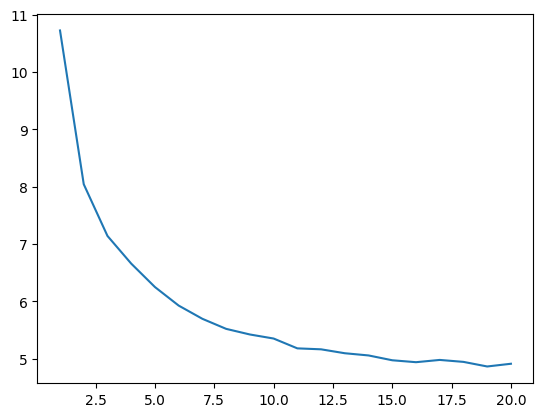

In [17]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_complex) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_complex)
plt.show()

El entrenamiento fue constante y progresivo, lográndose además el mejor resultado en pérdida.

In [21]:
model_complex = keras.models.load_model(model_name_complex)

In [22]:
generate_seq(model_complex, input_text_1, max_length=max_context_size, n_tokens=100)

'y entonces moisés a moisés: «¿que se ha de la tienda del encuentro de la tienda del encuentro de la tienda del encuent'

In [23]:
salidas = beam_search(model_complex, num_beams=10, num_tokens=100, input=input_text_1)
salidas_decoded = [decode(salida) for salida in salidas]
for salida in salidas_decoded:
    print(salida)

y entonces moisés habló yahveh había mandado a moisés: «¿quedará impuro hasta la tienda del encuentro de la tienda del
y entonces moisés habló yahveh había mandado a moisés: «¿quedará impuro hasta la tienda del encuentro de los israelita
y entonces moisés habló yahveh había mandado a moisés: «¿quedará impuro hasta la tienda del encuentro de la tierra de 
y entonces moisés habló yahveh había mandado a moisés: «¿quedará impuro hasta la tienda del encuentro de la tienda de 
y entonces moisés habló yahveh había mandado a moisés: «¿quedará impuro hasta la tienda del encuentro de la comunidad 
y entonces moisés habló yahveh había mandado a moisés: «¿quedará impuro hasta la tienda del encuentro de la morada de 
y entonces moisés habló yahveh había mandado a moisés: «¿quedará impuro hasta la tienda del encuentro de los hijos de 
y entonces moisés habló yahveh había mandado a moisés: «¿quedará impuro hasta la tienda del encuentro de sus hijos de 
y entonces moisés habló yahveh había mandado a m

In [24]:
salidas_sto = beam_search(model_complex, num_beams=10, num_tokens=100, input=input_text_1, temp=2, mode='sto')
salidas_sto_decoded = [decode(salida) for salida in salidas_sto]
for salida in salidas_sto_decoded:
    print(salida)

y entonces moisés así moisés: «¿podréis que yos diciendo: [1] y a aarón y se lo había moisés: «¿por escarlata y quedar
y entonces moisés así moisés: «¿podréis que yos diciendo: [1] y a aarón y se lo había moisés: «¿por escarlata y quedas
y entonces moisés así moisés: «¿podréis que yos diciendo: [1] y a aarón y se lo había moisés: «¿por escarlata y que ha
y entonces moisés así moisés: «¿podréis que yos diciendo: [1] y a aarón y se lo había moisés: «¿por escarlata y quedak
y entonces moisés así moisés: «¿podréis que yos diciendo: [1] y a aarón y se lo había moisés: «¿por escarlata y que é5
y entonces moisés así moisés: «¿podréis que yos diciendo: [1] y a aarón y se lo había moisés: «¿por escarlata y quedas
y entonces moisés así moisés: «¿podréis que yos diciendo: [1] y a aarón y se lo había moisés: «¿por escarlata y que po
y entonces moisés así moisés: «¿podréis que yos diciendo: [1] y a aarón y se lo había moisés: «¿por escarlata y queda 
y entonces moisés así moisés: «¿podréis que yos 

In [25]:
print(generate_seq(model_complex, input_text_2, max_length=max_context_size, n_tokens=150))
salidas = beam_search(model_complex, num_beams=10, num_tokens=150, input=input_text_2)
salidas_decoded = [decode(salida) for salida in salidas]
for salida in salidas_decoded:
    print(salida)
salidas_sto = beam_search(model_complex, num_beams=10, num_tokens=150, input=input_text_2, temp=2, mode='sto')
salidas_sto_decoded = [decode(salida) for salida in salidas_sto]
for salida in salidas_sto_decoded:
    print(salida)

y descendió fuego del cielo, y consumió el altar y el sacrificio, por el pecado de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro d
y descendió fuego del cielo, y consumió el altar y el sacrificio, por el sacrificio por el pecado de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la tien
y descendió fuego del cielo, y consumió el altar y el sacrificio, por el sacrificio por el pecado de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro, el sacerd
y descendió fuego del cielo, y consumió el altar y el sacrificio, por el sacrificio por el pecado de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro de la tienda del encuentro del altar 
y descendió fuego del cielo, y consumió el altar y el sacrificio, por el sacrificio por el pecado de la tienda del encuentro de la t

In [22]:
print(generate_seq(model_complex, input_text_3, max_length=max_context_size, n_tokens=40))
salidas = beam_search(model_complex, num_beams=10, num_tokens=40, input=input_text_3)
salidas_decoded = [decode(salida) for salida in salidas]
for salida in salidas_decoded:
    print(salida)
salidas_sto = beam_search(model_complex, num_beams=10, num_tokens=40, input=input_text_3, temp=2, mode='sto')
salidas_sto_decoded = [decode(salida) for salida in salidas_sto]
for salida in salidas_sto_decoded:
    print(salida)

y habló dios, diciendo a moisés: «¿que se ha de la tienda del e
y habló dios, diciendo a los israelitas de la tienda del encuen
y habló dios, diciendo a los israelitas de los israelitas de la
y habló dios, diciendo a los israelitas de los israelitas en el
y habló dios, diciendo a los israelitas de los israelitas de lo
y habló dios, diciendo a los israelitas y los israelitas de la 
y habló dios, diciendo a los israelitas de los israelitas y los
y habló dios, diciendo a los israelitas de los israelitas de su
y habló dios, diciendo a los israelitas de los israelitas y el 
y habló dios, diciendo a los israelitas de la tienda del encuer
y habló dios, diciendo a los israelitas de los israelitas en la
y habló dios, diciendo a moisés: [3] harás a moisés: «con su pu
y habló dios, diciendo a moisés: [3] harás a moisés: «con su ia
y habló dios, diciendo a moisés: [3] harás a moisés: «con su pr
y habló dios, diciendo a moisés: [3] harás a moisés: «con su da
y habló dios, diciendo a moisés: [3] har

In [23]:
print(generate_seq(model_complex, input_text_4, max_length=max_context_size, n_tokens=100))
salidas = beam_search(model_complex, num_beams=10, num_tokens=100, input=input_text_4)
salidas_decoded = [decode(salida) for salida in salidas]
for salida in salidas_decoded:
    print(salida)
salidas_sto = beam_search(model_complex, num_beams=10, num_tokens=100, input=input_text_4, temp=2, mode='sto')
salidas_sto_decoded = [decode(salida) for salida in salidas_sto]
for salida in salidas_sto_decoded:
    print(salida)

y sus hijos de la morada de la tienda del encuentro de la tienda del encuentro de la tienda del encuen
y el sacrificio por el pecado de la tienda del encuentro de la tienda del encuentro de la tienda del e
y el sacrificio por el pecado de la tienda del encuentro de la tienda del encuentro de los israelitas 
y el sacrificio por el pecado de la tienda del encuentro de la tienda del encuentro de los israelitas,
y el sacrificio por el pecado de la tienda del encuentro de la tienda del encuentro de los israelitas.
y el sacrificio por el pecado de la tienda del encuentro de la tienda del encuentro de la tierra de la
y el sacrificio por el pecado de la tienda del encuentro de la tienda del encuentro, el sacerdote lo q
y el sacrificio por el pecado de la tienda del encuentro de la tienda del encuentro, el sacerdote los 
y el sacrificio por el pecado de la tienda del encuentro de la tienda del encuentro de la tienda de la
y el sacrificio por el pecado de la tienda del encuentro de la tienda del

Aunque se pueden evidenciar algunas mejoras con respecto a las anteriores alternativas propuestas, se vuelven a repetir los mismos problemas y las palabras utilizadas por este modelo son muy similares así como los problemas de semántica, e incluso se repite la problemática de la invensión de palabras inexistentes cuando se utiliza una temperatura de 2 con generación estocástica.

### Comparación de modelos

Finalmente, comparemos las métricas pérdida (`loss`) y `perplexity` media:

| Modelo                            | Arquitectura principal                  | Loss   | Mean Perplexity |
|-----------------------------------|-----------------------------------------|--------|------------------|
| **1. SimpleRNN (baseline)**       | One-hot + SimpleRNN(200)                | 1.4100 | 4.8024           |
| **2. GRU + Embedding**            | Embedding + GRU(64)                     | 1.4793 | 5.8841           |
| **3. LSTM (ligero)**              | One-hot + LSTM(128)                     | 1.5272 | 5.5143           |
| **4. LSTM (doble capa)**       | One-hot + LSTM(200) + LSTM(100)         | 1.3539 | 4.9113           |

- El **modelo 4**, con doble capa LSTM obtuvo el **mejor resultado en términos de pérdida (`loss`)**, lo cual indica que se ajustó mejor a los datos de entrenamiento.
- El **modelo 1** (SimpleRNN), aunque más simple, logró la **mejor `perplexity` media**, si consideramos el menor valor como mejor, dentro del rango entre 4 y 6. Esto sugiere que es un modelo muy competitivo pese a su arquitectura básica.
- El **modelo 2**, basado en `GRU` con `Embedding`, tuvo el rendimiento bajo. Esto podría deberse a que un vocabulario pequeño (62) no se beneficia tanto de embeddings, y las GRU con pocas unidades pueden no capturar patrones suficientes.
- El **modelo 3**, un `LSTM` ligero, también quedó por detrás, pero cerca del modelo GRU.

### Próximos pasos

Continuar experimentando con el **modelo 4**, variando unidades, dropout, o cantidad de capas.